# Reproducibility assessment of read alignment tools
## This is a draft (should be adapted once the naming convention is correct)

In [1]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from natsort import natsorted, natsort_keygen
import re
from itertools import chain

## Set up working directory, sampled ids, and replicate types

In [2]:
csv_dir="/Users/peicer/projects/github_releases/reproducibility/notebooks/sample_input/bam_results/"

sample_ids=["ERR009308", 
            "ERR009309", 
            "ERR009332", 
            "ERR009345", 
            "ERR013101"]

replicates=["both1", 
           "both2", 
           "both3", 
           "sh1", 
           "sh2", 
           "sh3", 
           "rc"]

# working_directory should contain a separate folder for each tools
tools = sorted([entry.name for entry in os.scandir(csv_dir) if entry.is_dir()])
print(f'Detected tools in {csv_dir}:\n {tools}')

Detected tools in /Users/peicer/projects/github_releases/reproducibility/notebooks/sample_input/bam_results/:
 ['bowtie2', 'bwa2', 'hisat2', 'minimap2', 'ngm', 'smalt', 'snap', 'subread']


In [3]:
l = [[1,2,3],[4,5,6]]
flattened_l = [item for sublist in l for item in sublist]
print(flattened_l)

[1, 2, 3, 4, 5, 6]


In [4]:
# list of csv_files within the tool directories 
csv_files = list(chain.from_iterable([glob.glob(f'{csv_dir}{tool}/*.csv') for tool in tools]))

In [5]:
# read csv files into dataframe, add selected samp IDs and replicates to the dataframe

dataframes = []

for file in csv_files:
    df = pd.read_csv(file)
    filename = os.path.splitext(os.path.basename(file))[0]
    tool_name = os.path.basename(os.path.dirname(file))
    df['tool'] = tool_name
    
    for rep_type in replicates:
        if rep_type in filename:
            df['replicate'] = rep_type
            break
    
    for sid in sample_ids:
        if sid in filename:
            df['sampID'] = sid
        
    dataframes.append(df)
    
df_combined = pd.concat(dataframes)
df_combined = df_combined.sort_values(["tool", "sampID" ,"replicate"], key=natsort_keygen())

# reproducibility assessment metrics
features = df_combined['FEATURE'].unique()

In [6]:
# pivot dataframe to prepare for pplots

df_pivot = df_combined.pivot(index=['tool', 'replicate', 'sampID'], values='PERCENTAGE', columns='FEATURE')
df = df_pivot.reset_index()

# average percentages for the same replicate types
df['repType'] = df['replicate'].apply(lambda x: re.sub(r'\d+', '', x))
avg_df = df.groupby(['repType', 'sampID', 'tool'])[features].mean().reset_index()
replicate_types = avg_df['repType'].unique()

# add new results (differences among some metrics)
avg_df['non-identical'] = 100-avg_df['Identical']
avg_df['Uncommon_unambigous'] = 100-avg_df['Common_unambiguous']

avg_df.head()


FEATURE,repType,sampID,tool,Total_reads,Mapped_reads,Unambigous_type1,Unambigous_type2,Common_unambiguous,Inconsistent_type1,Inconsistent_type2,Identical,Consistent_global_inconsistent_local,Inconsistent_global,Multi_mapped,non-identical,Uncommon_unambigous
0,both,ERR009308,bowtie2,100.0,98.779,82.002,69.843,69.165,0.310,0.178,95.527,0.536000,3.110000,0.340000,4.473,30.835
1,both,ERR009308,bwa2,100.0,99.699,100.000,100.000,100.000,0.002,0.001,95.422,0.065333,0.699333,3.810333,4.578,0.000
2,both,ERR009308,hisat2,100.0,90.053,95.027,92.129,91.883,0.020,0.018,99.183,0.039000,0.364000,0.376000,0.817,8.117
3,both,ERR009308,minimap2,100.0,99.212,100.000,100.000,100.000,0.098,0.040,84.024,0.004000,6.624000,9.211000,15.976,0.000
4,both,ERR009308,ngm,100.0,99.579,100.000,100.000,100.000,0.000,0.000,99.978,0.000000,0.010000,0.012000,0.022,0.000


## Bar plots for reproducibility metrics
### to be completed, improved if necessary (@Belin and @Mike)

In [7]:
# bar plot with error bars
def plot_bar_err(data_df, info, category, label, line, val=None):
#     plt.figure()
    plt.figure(figsize=(14, 6))

    ax=sns.barplot(x = "tool", y = info, hue = category, data = data_df,
                palette = 'Set1',
                order = tools, 
                capsize=0.05,  errwidth=2, ci='sd')
    if line:
        ax.axhline(val, color='black', linestyle='--')
    ax.set(xlabel='tools', ylabel=label)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.legend(bbox_to_anchor=(1, 1))

In [8]:
# cat plot to distinguish multiple groups
def plot_cat(data_df, category, xval, label):
    
    
    df_melted = data_df.melt(category, var_name='values')
#     df_melted['value'] = 100-df_melted['value']
#     print(df_melted)
    
    sns.set(style='whitegrid')
    g=sns.catplot(x=xval, y='value', hue='values', col='repType', data=df_melted,
                  palette='Set1',
                  order=tools, 
                  capsize=0.05, errwidth=2, ci='sd', kind='bar'
                 )
    
#     ax.set(xlabel='tools', ylabel=label)
    g.set_axis_labels("replicate types", label)
    g.set_xticklabels(tools)
    g.set_titles("replicate type = {col_name}")
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
#     g.legend(bbox_to_anchor=(1, 1))


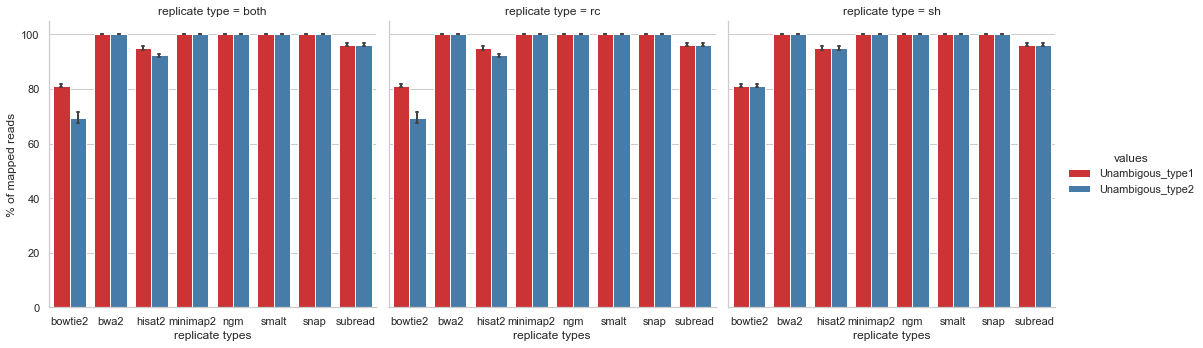

In [9]:
plot_cat(avg_df[['repType', 'sampID', 'tool', 'Unambigous_type1', 'Unambigous_type2']], 
              ['tool', 'repType', 'sampID'], 'tool', '% of mapped reads')


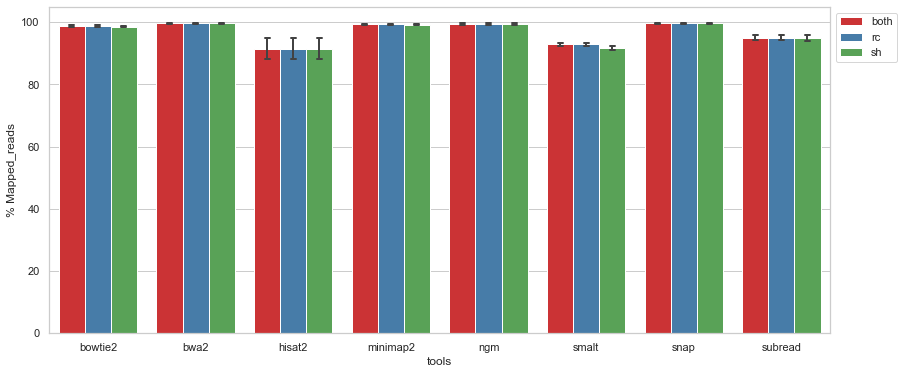

In [10]:
plot_bar_err(avg_df, 'Mapped_reads', 'repType' ,'% Mapped_reads', False, 5)


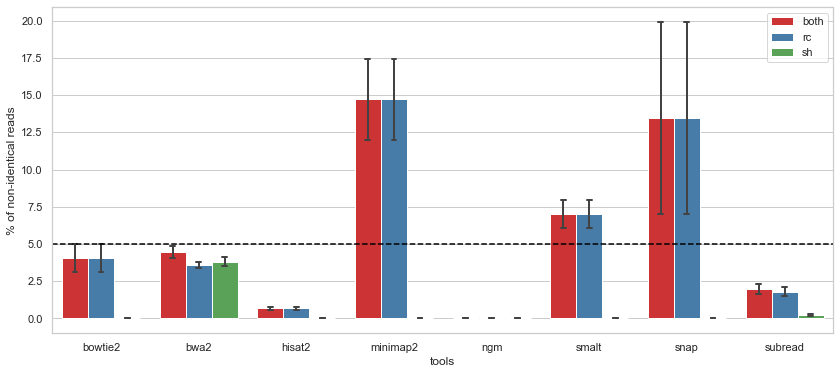

In [11]:
plot_bar_err(avg_df, 'non-identical', 'repType' ,'% of non-identical reads', True, 5)


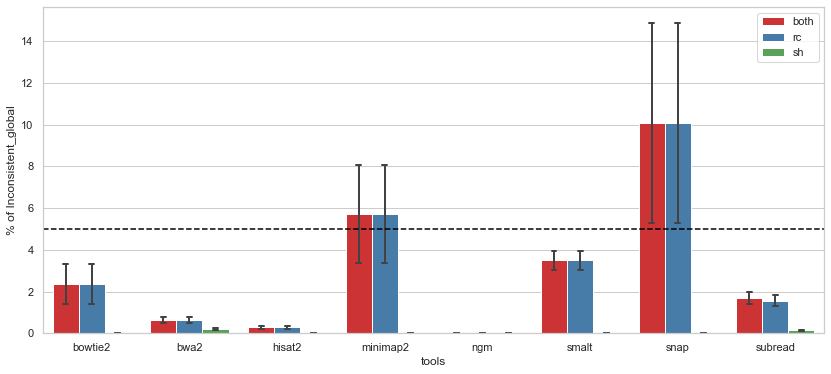

In [12]:
plot_bar_err(avg_df, 'Inconsistent_global', 'repType', '% of Inconsistent_global', True, 5)


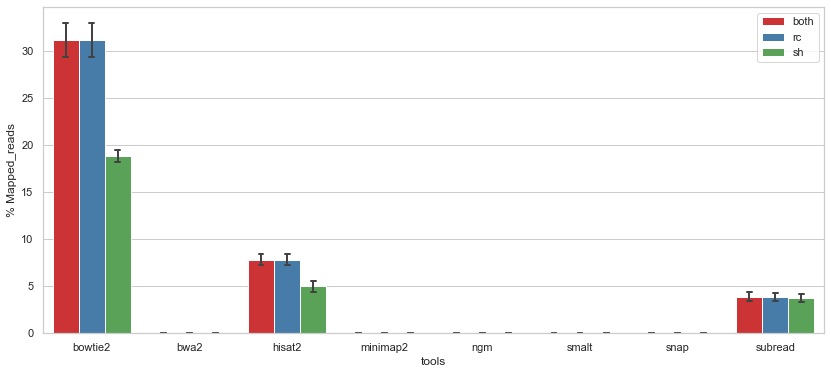

In [13]:
plot_bar_err(avg_df, 'Uncommon_unambigous', 'repType' ,'% Mapped_reads', False, 5)


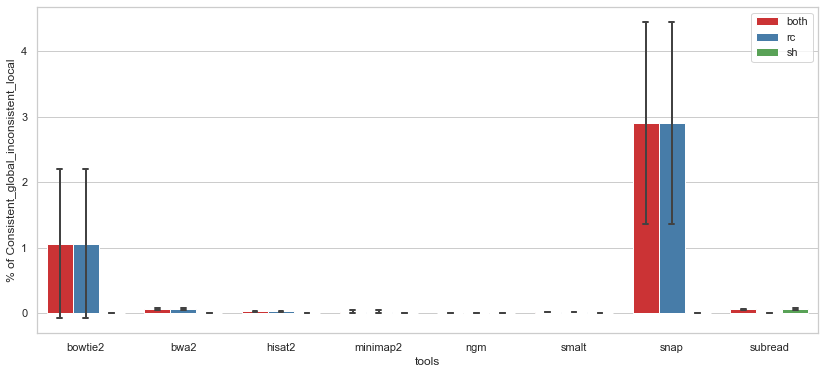

In [14]:
plot_bar_err(avg_df, 'Consistent_global_inconsistent_local', 
             'repType', '% of Consistent_global_inconsistent_local', False)


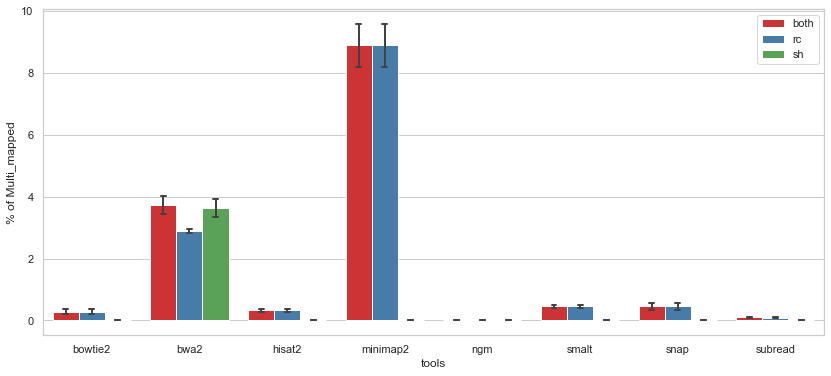

In [15]:
plot_bar_err(avg_df, 'Multi_mapped', 'repType', '% of Multi_mapped', False)

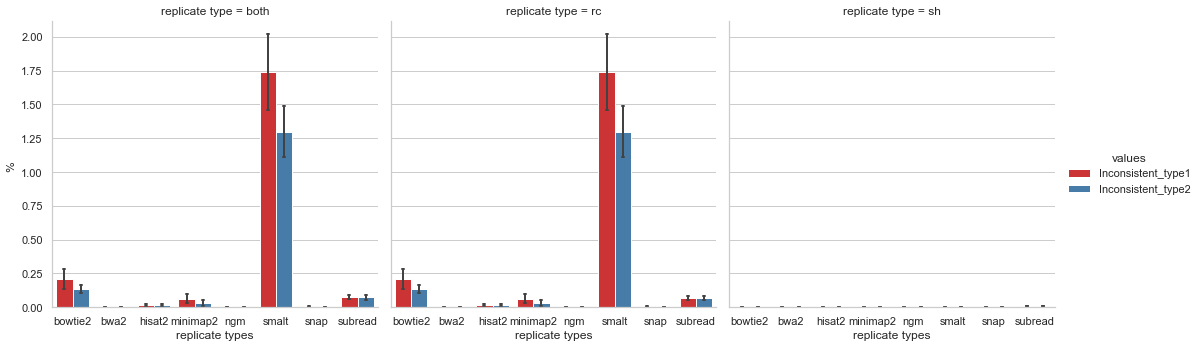

In [16]:
plot_cat(avg_df[['repType', 'sampID', 'tool', 'Inconsistent_type1', 'Inconsistent_type2']], 
              ['tool', 'repType', 'sampID'], 'tool', '% ')

In [17]:
avg_df


FEATURE,repType,sampID,tool,Total_reads,Mapped_reads,Unambigous_type1,Unambigous_type2,Common_unambiguous,Inconsistent_type1,Inconsistent_type2,Identical,Consistent_global_inconsistent_local,Inconsistent_global,Multi_mapped,non-identical,Uncommon_unambigous
0,both,ERR009308,bowtie2,100.0,98.779,82.002,69.843000,69.165000,0.310000,0.178000,95.527,0.536000,3.110000,0.340000,4.473,30.835000
1,both,ERR009308,bwa2,100.0,99.699,100.000,100.000000,100.000000,0.002000,0.001000,95.422,0.065333,0.699333,3.810333,4.578,0.000000
2,both,ERR009308,hisat2,100.0,90.053,95.027,92.129000,91.883000,0.020000,0.018000,99.183,0.039000,0.364000,0.376000,0.817,8.117000
3,both,ERR009308,minimap2,100.0,99.212,100.000,100.000000,100.000000,0.098000,0.040000,84.024,0.004000,6.624000,9.211000,15.976,0.000000
4,both,ERR009308,ngm,100.0,99.579,100.000,100.000000,100.000000,0.000000,0.000000,99.978,0.000000,0.010000,0.012000,0.022,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,sh,ERR013101,minimap2,100.0,99.211,100.000,100.000000,100.000000,0.000000,0.000000,100.000,0.000000,0.000000,0.000000,0.000,0.000000
116,sh,ERR013101,ngm,100.0,99.047,100.000,100.000000,100.000000,0.000000,0.000000,99.992,0.000000,0.001333,0.006667,0.008,0.000000
117,sh,ERR013101,smalt,100.0,92.658,100.000,100.000000,100.000000,0.000000,0.000000,100.000,0.000000,0.000000,0.000000,0.000,0.000000
118,sh,ERR013101,snap,100.0,99.649,100.000,100.000000,100.000000,0.000000,0.000000,100.000,0.000000,0.000000,0.000000,0.000,0.000000


In [18]:
features
# avg_df

array(['Total_reads', 'Mapped_reads', 'Unambigous_type1',
       'Unambigous_type2', 'Common_unambiguous', 'Inconsistent_type1',
       'Inconsistent_type2', 'Identical',
       'Consistent_global_inconsistent_local', 'Inconsistent_global',
       'Multi_mapped'], dtype=object)

## Venn diagrams (@ Mike)

## Violing plots for position difference (@Mike)

## CPU, run time, etc. violin plots (@Belin)
### Below is an example with two tools, should be done for all tools and indexing
### we should decide if it is worth reporting by replicate type

In [138]:
stats_file = "/Users/peicer/projects/github_releases/reproducibility/notebooks/sample_input/stats_results/tools_stats.csv"

In [139]:
df_stats = pd.read_csv(stats_file)
df_stats[df_stats['tool'] == 'ngm']['ram'].unique()
df_stats.head()

,Unnamed: 0,tool,sampID,repType,cpu,ram,utime
0,0,minimap2,ERR009308,g,1.042944,11.956,0.920551
1,1,minimap2,ERR009308,rc,1.578615,11.956,1.426988
2,2,minimap2,ERR009308,sh1,1.359512,11.956,1.201292
3,3,minimap2,ERR009308,sh2,0.974518,11.956,0.854226
4,4,minimap2,ERR009308,both1,2.050003,11.956,1.874380


In [140]:
df_stats['repType'] = df_stats['repType'].apply(lambda x: re.sub(r'\d+', '', x))
avg_df_stats = df_stats.groupby(['tool', 'sampID', 'repType'])['cpu', 'ram', 'utime'].mean().reset_index()
avg_df_stats['repType'].unique()
avg_df_stats.head()


/var/folders/b_/j2rtwzb11zld_833hqj9381h0000gr/T/ipykernel_3875/2063186492.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_df_stats = df_stats.groupby(['tool', 'sampID', 'repType'])['cpu', 'ram', 'utime'].mean().reset_index()


,tool,sampID,repType,cpu,ram,utime
0,minimap2,ERR009308,both,1.699052,11.956000,1.568528
1,minimap2,ERR009308,g,1.042944,11.956000,0.920551
2,minimap2,ERR009308,rc,1.578615,11.956000,1.426988
3,minimap2,ERR009308,sh,1.087752,11.956000,0.965357
4,minimap2,ERR009309,both,1.277425,12.081333,1.169250


In [141]:
avg_df_stats[(avg_df_stats['tool'] == 'minimap2') & (avg_df_stats['repType'] == 'both')]['ram'].unique()

array([11.956     , 12.08133333, 11.95633333])

In [162]:
tool_clrs = ['blue', 'darkorange', 'lime', 'red', 'blueviolet', 'firebrick', 
             'fuchsia', 'lightgray', 'gold', 'aqua', 'tomato']

def plot_stats(df, info, ylabel):
    
    plt.figure(figsize=(18,5))
    
    my_order = df.groupby(by='tool')[[info]].median()

    my_order = my_order.sort_values(by=info).index
#     print(my_order)


    ax = sns.violinplot(x="tool", y=info, hue='repType', 
                    data=df_stats, palette=tool_clrs, scale='width', order=my_order, inner='points')

    plt.ylabel(ylabel, fontsize=20, labelpad=10)
    plt.xlabel('Aligner', fontsize=20, labelpad=10)
    plt.xticks(fontsize=19)
    sns.despine()
    
# cat plot to distinguish multiple groups
# def plot_stats2(df, info, xval, label):
    
    
#     df_melted = df.melt(info, var_name='values')
# #     print(df_melted)

    
#     sns.set(style='whitegrid')
#     g=sns.catplot(x=xval, y='value', hue='values', col='repType', data=df_melted,
#                   palette='Set1',
#                   order=tools, 
#                   capsize=0.05, errwidth=2, ci='sd', kind='violin',
#                   col_wrap=2)
    
#     g.set_axis_labels("replicate types", label)
#     g.set_xticklabels(tools)
#     g.set_titles("replicate type = {col_name}")

    
    

In [119]:
avg_df_stats.head(2)

,tool,sampID,repType,cpu,ram,utime
0,minimap2,ERR009308,both,6116.586333,11.956,5646.701333
1,minimap2,ERR009308,g,3754.597000,11.956,3313.985000


In [129]:
# plot_stats2(avg_df_stats[['repType', 'sampID', 'tool', 'cpu']], 
#               ['tool', 'repType', 'sampID'], 'tool', '% of mapped reads')

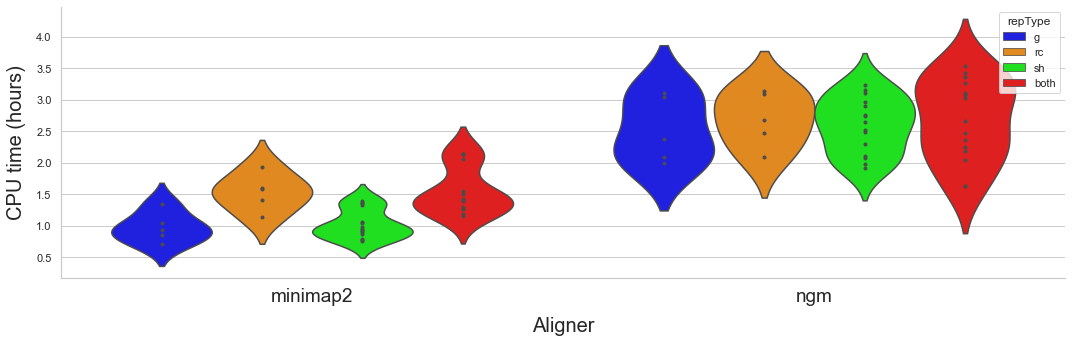

In [163]:
plot_stats(avg_df_stats, 'cpu', 'CPU time (hours)')

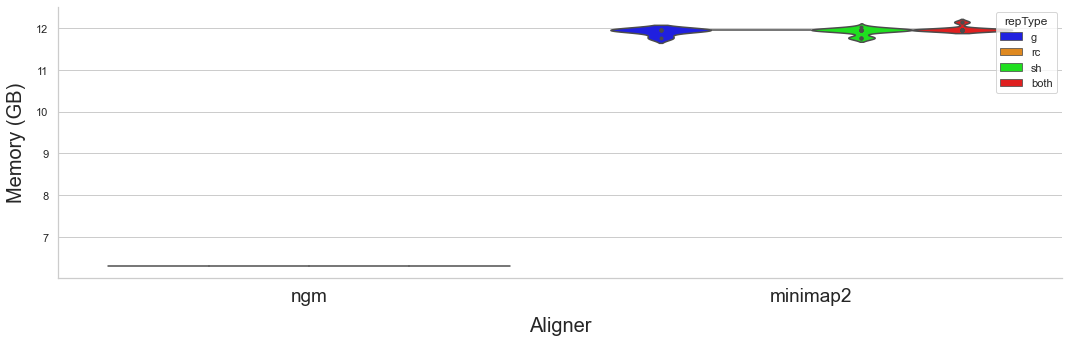

In [164]:
plot_stats(avg_df_stats, 'ram' ,'Memory (GB)')

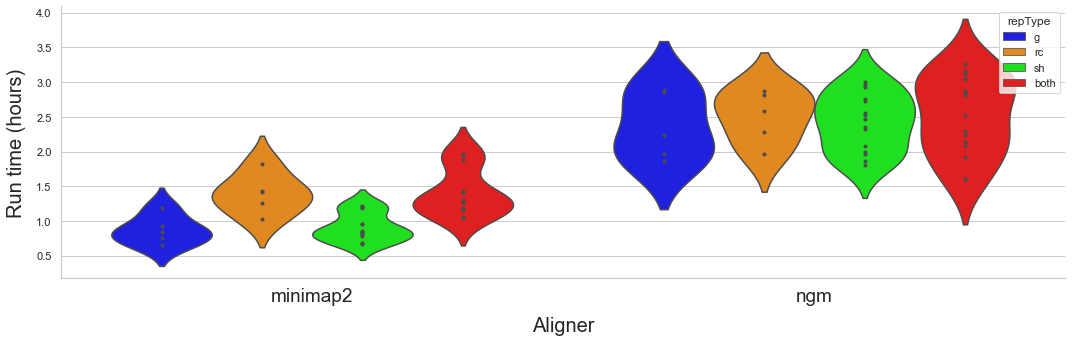

In [165]:
plot_stats(avg_df_stats, 'utime' ,'Run time (hours)')